CHANGE THIS FILE TO THE ANOMALY FILE!!!

# Packages

In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
xlsx_file = '../data/swat-2015-data.xlsx'
df = pd.read_excel(xlsx_file, engine='openpyxl', header=1)  # Read the file

C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## 3. Spectral Residual

We borrow the package from [Y-bar](https://github.com/y-bar)'s Spectral Residual tool.

Here we choose to process on 29 Dec 2015's data. 

Ref link: [https://github.com/y-bar/ml-based-anomaly-detection](https://github.com/y-bar/ml-based-anomaly-detection).

In [9]:
# Reload as numpy.array
data = np.load('../data/swat-2015-data.npy')

# Dataset Start Time and End Time
df_time_start = np.array('2015-12-28T10:00:00', dtype=np.datetime64)
df_time_end = np.array('2016-01-02T02:59:59', dtype=np.datetime64)
time_start = np.array('2015-12-29T00:00:00', dtype=np.datetime64)
time_end = np.array('2015-12-30T00:00:00', dtype=np.datetime64)

# Index for 29 Dec 2015's data
idx_start = int((time_start - df_time_start) / np.timedelta64(1, 's'))
idx_end = int((time_end - df_time_start) / np.timedelta64(1, 's'))

# Sample data on 29 Dec 2015
sample = data[idx_start:idx_end, 1]

In [10]:
import sys; sys.path.append('../')
from src.silency import Silency

# Init spectral residual processor
# Args follow original repo's suggestion:
# - amp_window_size: should less than period
# - series_window_size: should less than period
# - score_window_size: should larger than perido
processor = Silency(amp_window_size=1000, 
                    series_window_size=1000, 
                    score_window_size=5000)

# Processed by spectral residual method
anomaly_score = processor.generate_anomaly_score(sample)

c:\Users\Hp\Documents\GitHub\CENG488-Research\tool-swat-preprocess-master\notebook\..\src\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


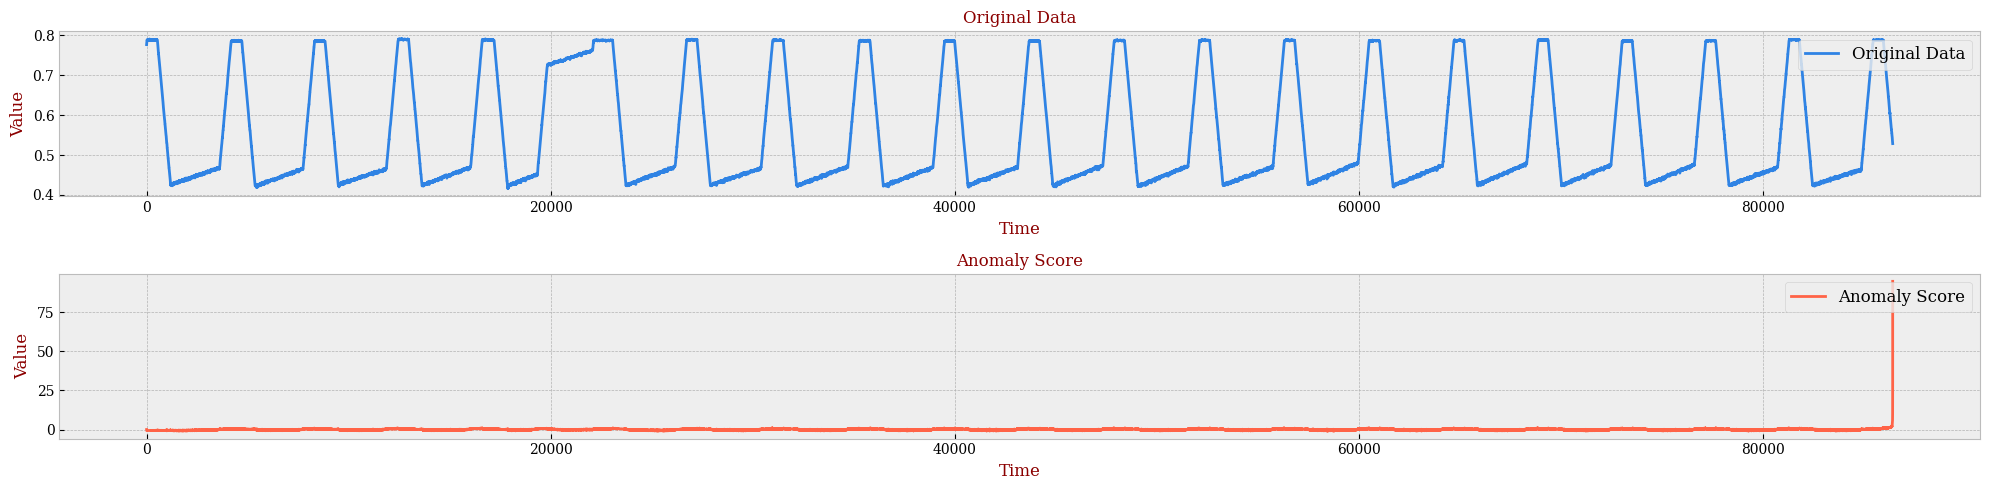

In [11]:
x = range(idx_end - idx_start)

with plt.style.context('bmh'):
    font = {'color': 'darkred', 'size': 12, 'family': 'serif'}
    font_legend = {'size': 12, 'family': 'serif'}

    fig, axs = plt.subplots(2, 1, figsize=(20, 5))

    axs[0].plot(x, sample, label='Original Data', color='#2f83e4')
    axs[0].set_xlabel('Time', fontdict=font)
    axs[0].set_ylabel('Value', fontdict=font)
    axs[0].set_title('Original Data', fontdict=font)
    axs[0].legend(loc='upper right', prop=font_legend)
    labels = axs[0].get_xticklabels() + axs[0].get_yticklabels()
    [label.set_fontname('serif') for label in labels]

    axs[1].plot(x, anomaly_score, label='Anomaly Score', color='tomato')
    axs[1].set_xlabel('Time', fontdict=font)
    axs[1].set_ylabel('Value', fontdict=font)
    axs[1].set_title('Anomaly Score', fontdict=font)
    axs[1].legend(loc='upper right', prop=font_legend)
    labels = axs[1].get_xticklabels() + axs[1].get_yticklabels()
    [label.set_fontname('serif') for label in labels]

plt.tight_layout()
plt.savefig('../fig/swat-2015-sr-sample.png')

### Multi Process

Here we will process SR on every features. For SWaT dataset, we can see all features have similar periods, so here we can use the same processor setting. 

In [12]:
anomaly_score_list = []
for i in range(51):
    sample = data[idx_start:idx_end, i]
    anomaly_score = processor.generate_anomaly_score(sample)
    anomaly_score_list.append(anomaly_score)

c:\Users\Hp\Documents\GitHub\CENG488-Research\tool-swat-preprocess-master\notebook\..\src\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
c:\Users\Hp\Documents\GitHub\CENG488-Research\tool-swat-preprocess-master\notebook\..\src\silency.py:24: RuntimeWarning: divide by zero encountered in log
  spectral_residual = np.exp(np.log(mag) - series_filter(np.log(mag), self.amp_window_size))
c:\Users\Hp\Documents\GitHub\CENG488-Research\tool-swat-preprocess-master\notebook\..\src\util.py:14: RuntimeWarning: invalid value encountered in subtract
  filter_values[kernel_size:] = filter_values[kernel_size:] - filter_values[:-kernel_size]
c:\Users\Hp\Documents\GitHub\CENG488-Research\tool-swat-preprocess-master\notebook\..\src\silency.py:24: RuntimeWarning: invalid value encountered in subtract
  spectral_residual = np.exp(np.log(mag) - series_filter(np.log(mag), self.amp_window_size))


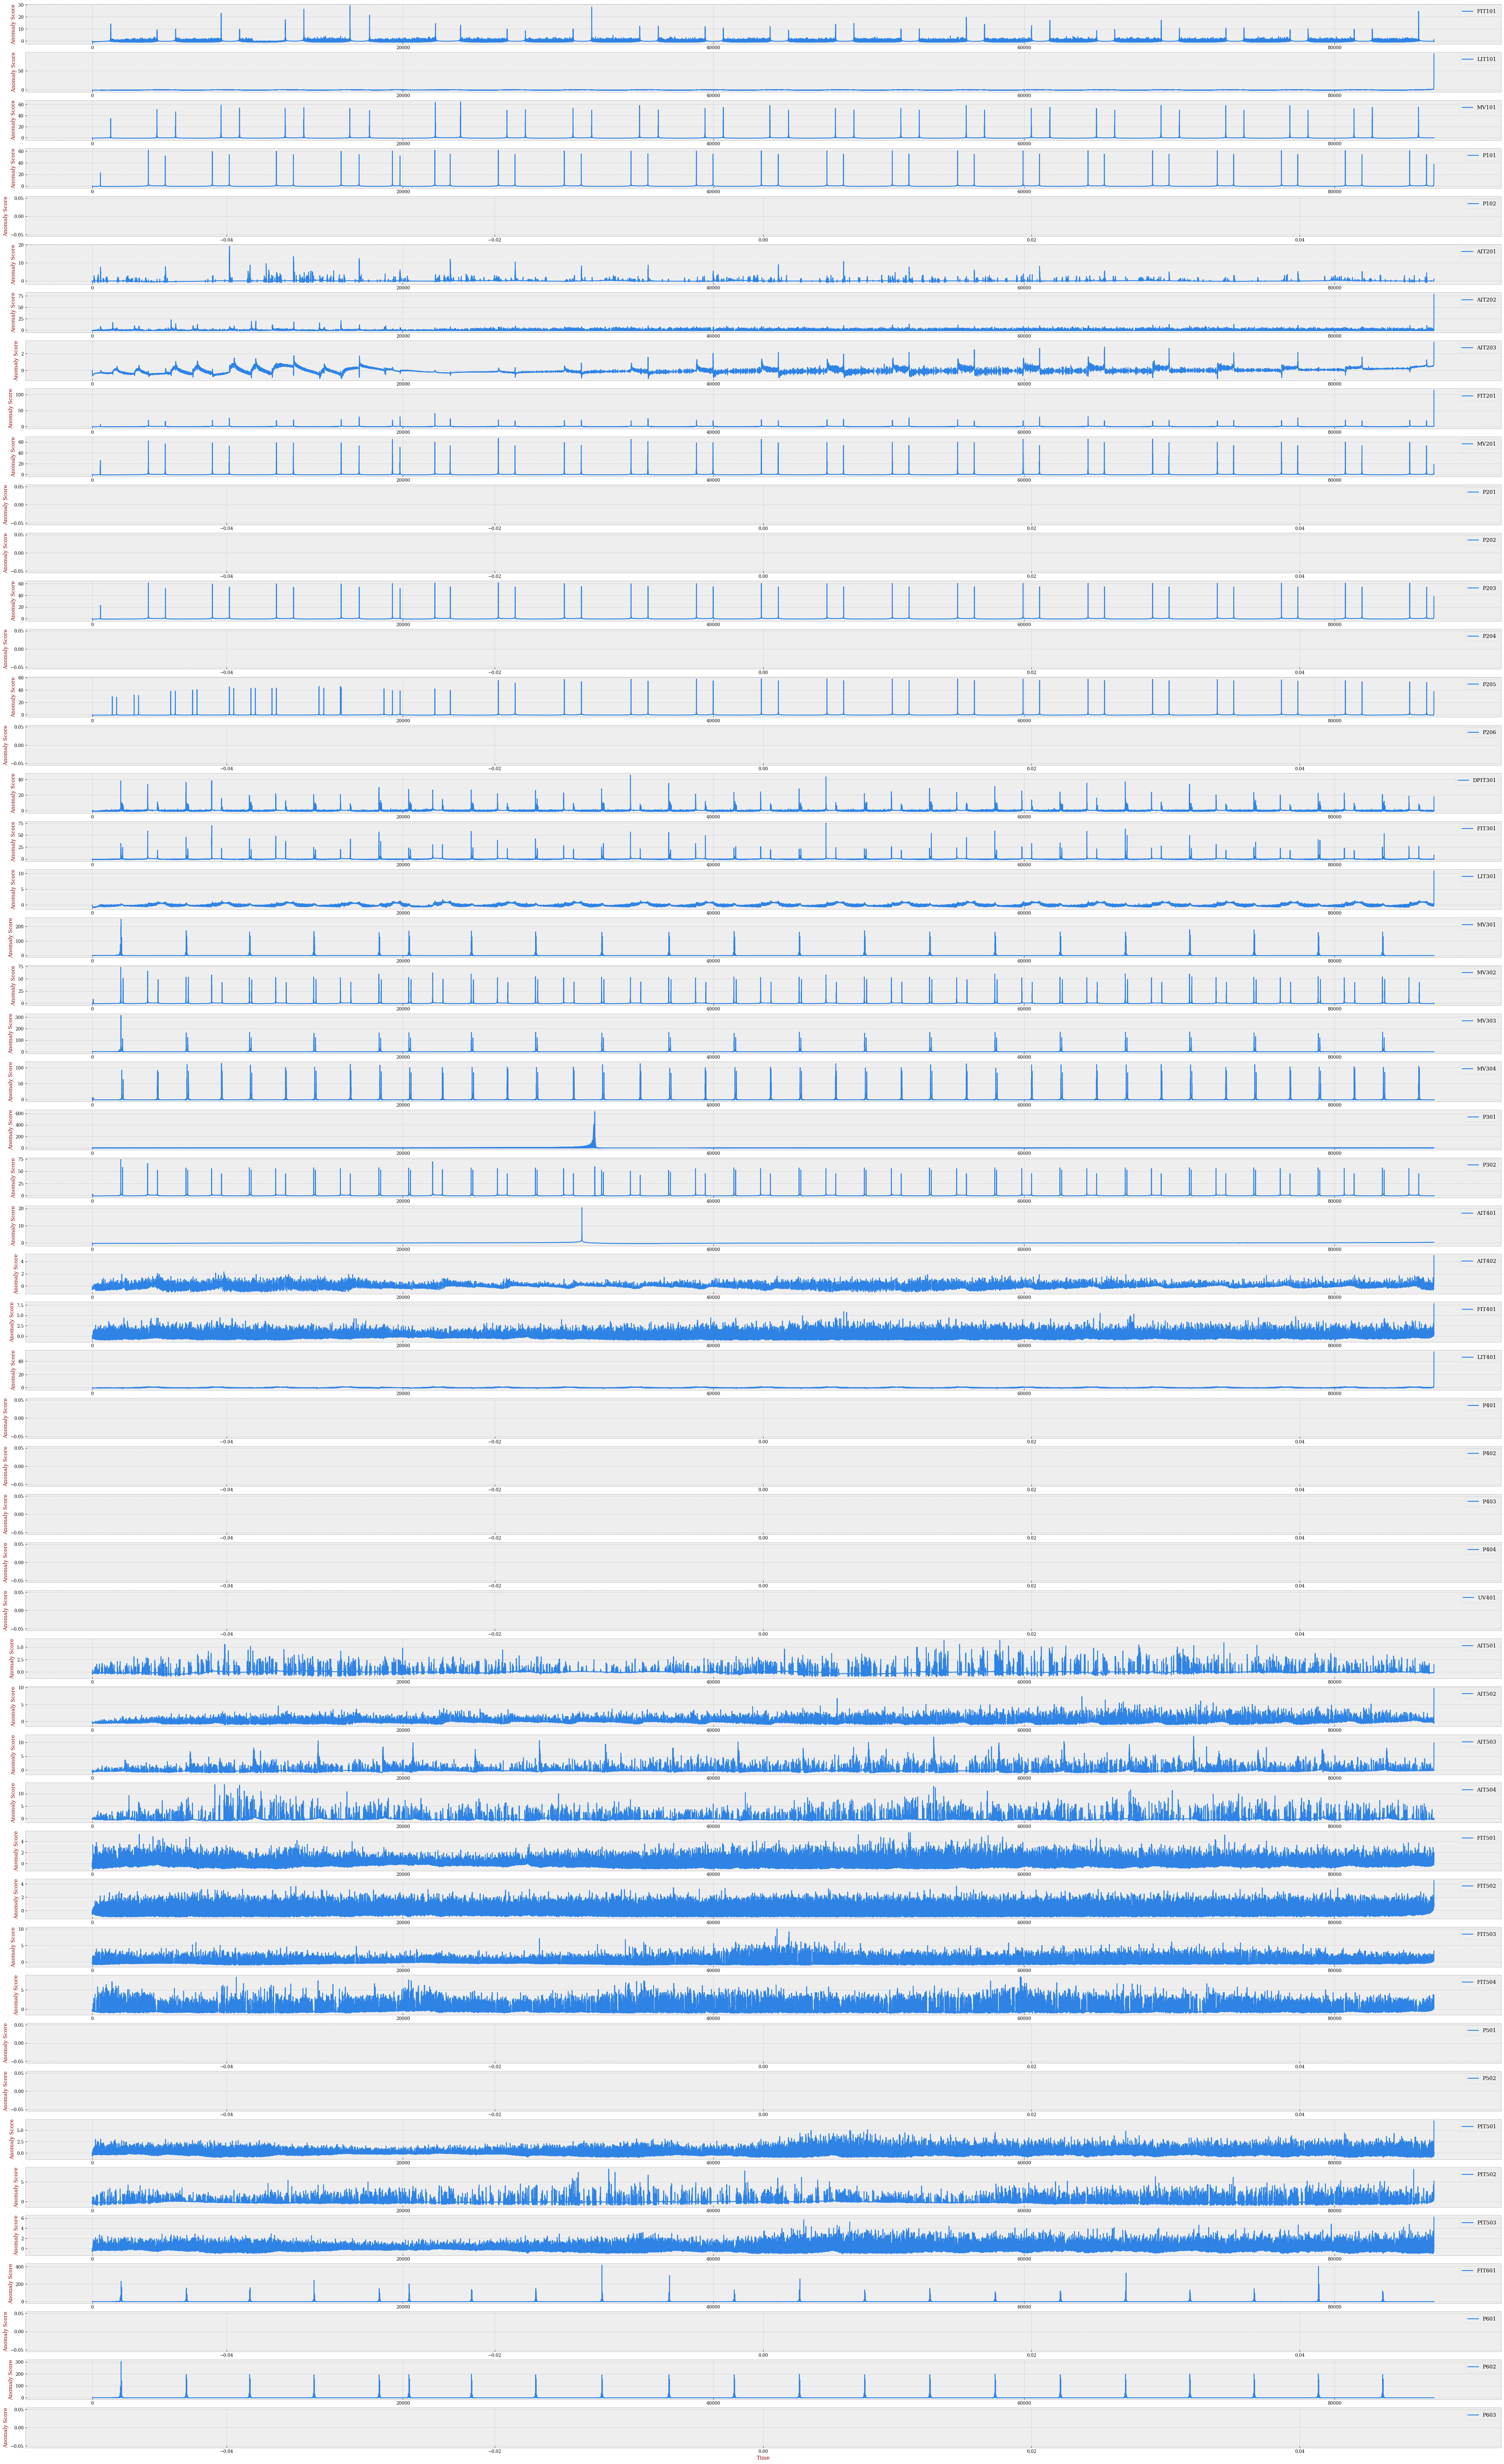

In [13]:
# Reload as numpy.array
data = np.load('../data/swat-2015-data.npy')
x = range(idx_end - idx_start)

with plt.style.context('bmh'):
    font = {'color': 'darkred', 'size': 12, 'family': 'serif'}
    font_legend = {'size': 12, 'family': 'serif'}

    fig, axs = plt.subplots(51, 1, figsize=(60, 100))

    for i in range(51):
        axs[i].plot(x, anomaly_score_list[i], label=df.columns[i+1], color='#2f83e4')
        axs[i].set_xlabel('Time', fontdict=font)
        axs[i].set_ylabel('Anomaly Score', fontdict=font)
        axs[i].legend(loc='upper right', prop=font_legend)
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels()
        [label.set_fontname('serif') for label in labels]

plt.savefig('../fig/swat-2015-sr.png')

## 4. Seasonlity Remove

After the preprocess of SR, we can see that for some features, we still hard to find anomaly part. Compare with original dataset, we reasonaly think it's because those features have too sharp value jump, so instead of using SR method on these features, we here apply some seasonality remove method. 

We use the method `seasonal_decompose` method from `statsmodels` package. 

In [14]:
sample = data[idx_start:idx_end, 1]

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sample, period=2000, extrapolate_trend='freq')
trend = result.trend

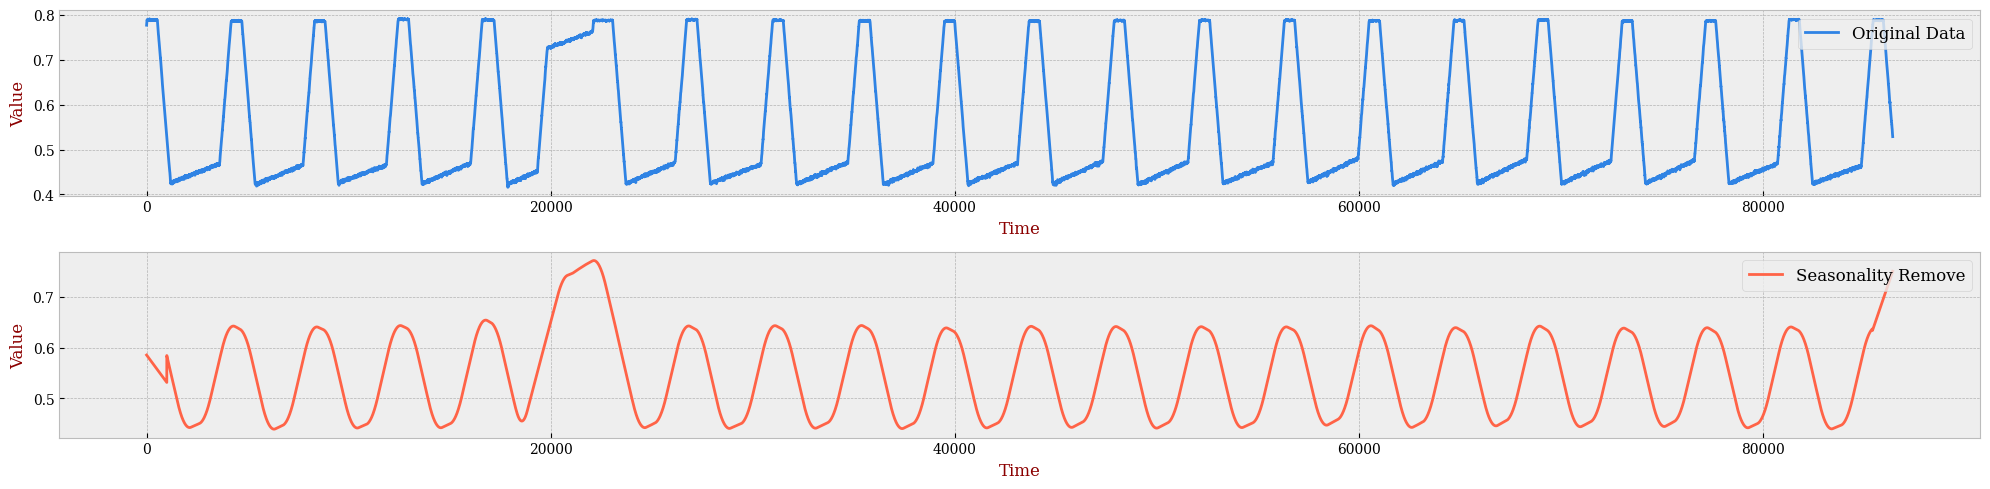

In [17]:
x = range(idx_end - idx_start)

with plt.style.context('bmh'):
    font = {'color': 'darkred', 'size': 12, 'family': 'serif'}
    font_legend = {'size': 12, 'family': 'serif'}

    fig, axs = plt.subplots(2, 1, figsize=(20, 5))

    axs[0].plot(x, sample, label='Original Data', color='#2f83e4')
    axs[0].set_xlabel('Time', fontdict=font)
    axs[0].set_ylabel('Value', fontdict=font)
    axs[0].legend(loc='upper right', prop=font_legend)
    labels = axs[0].get_xticklabels() + axs[0].get_yticklabels()
    [label.set_fontname('serif') for label in labels]

    axs[1].plot(x, trend, label='Seasonality Remove', color='tomato')
    axs[1].set_xlabel('Time', fontdict=font)
    axs[1].set_ylabel('Value', fontdict=font)
    axs[1].legend(loc='upper right', prop=font_legend)
    labels = axs[1].get_xticklabels() + axs[1].get_yticklabels()
    [label.set_fontname('serif') for label in labels]

plt.tight_layout()
plt.savefig('../fig/swat-2015-seasonal-remove.png')

In [18]:
import sys; sys.path.append('../')
from src.silency import Silency

# Init spectral residual processor
# Args follow original repo's suggestion:
# - amp_window_size: should less than period
# - series_window_size: should less than period
# - score_window_size: should larger than perido
processor = Silency(amp_window_size=1500, 
                    series_window_size=1500, 
                    score_window_size=3000)

# Processed by spectral residual method
anomaly_score = processor.generate_anomaly_score(trend)

c:\Users\Hp\Documents\GitHub\CENG488-Research\tool-swat-preprocess-master\notebook\..\src\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


In [19]:
anomaly_score[83000:] = 0
anomaly_score[:2000] = 0

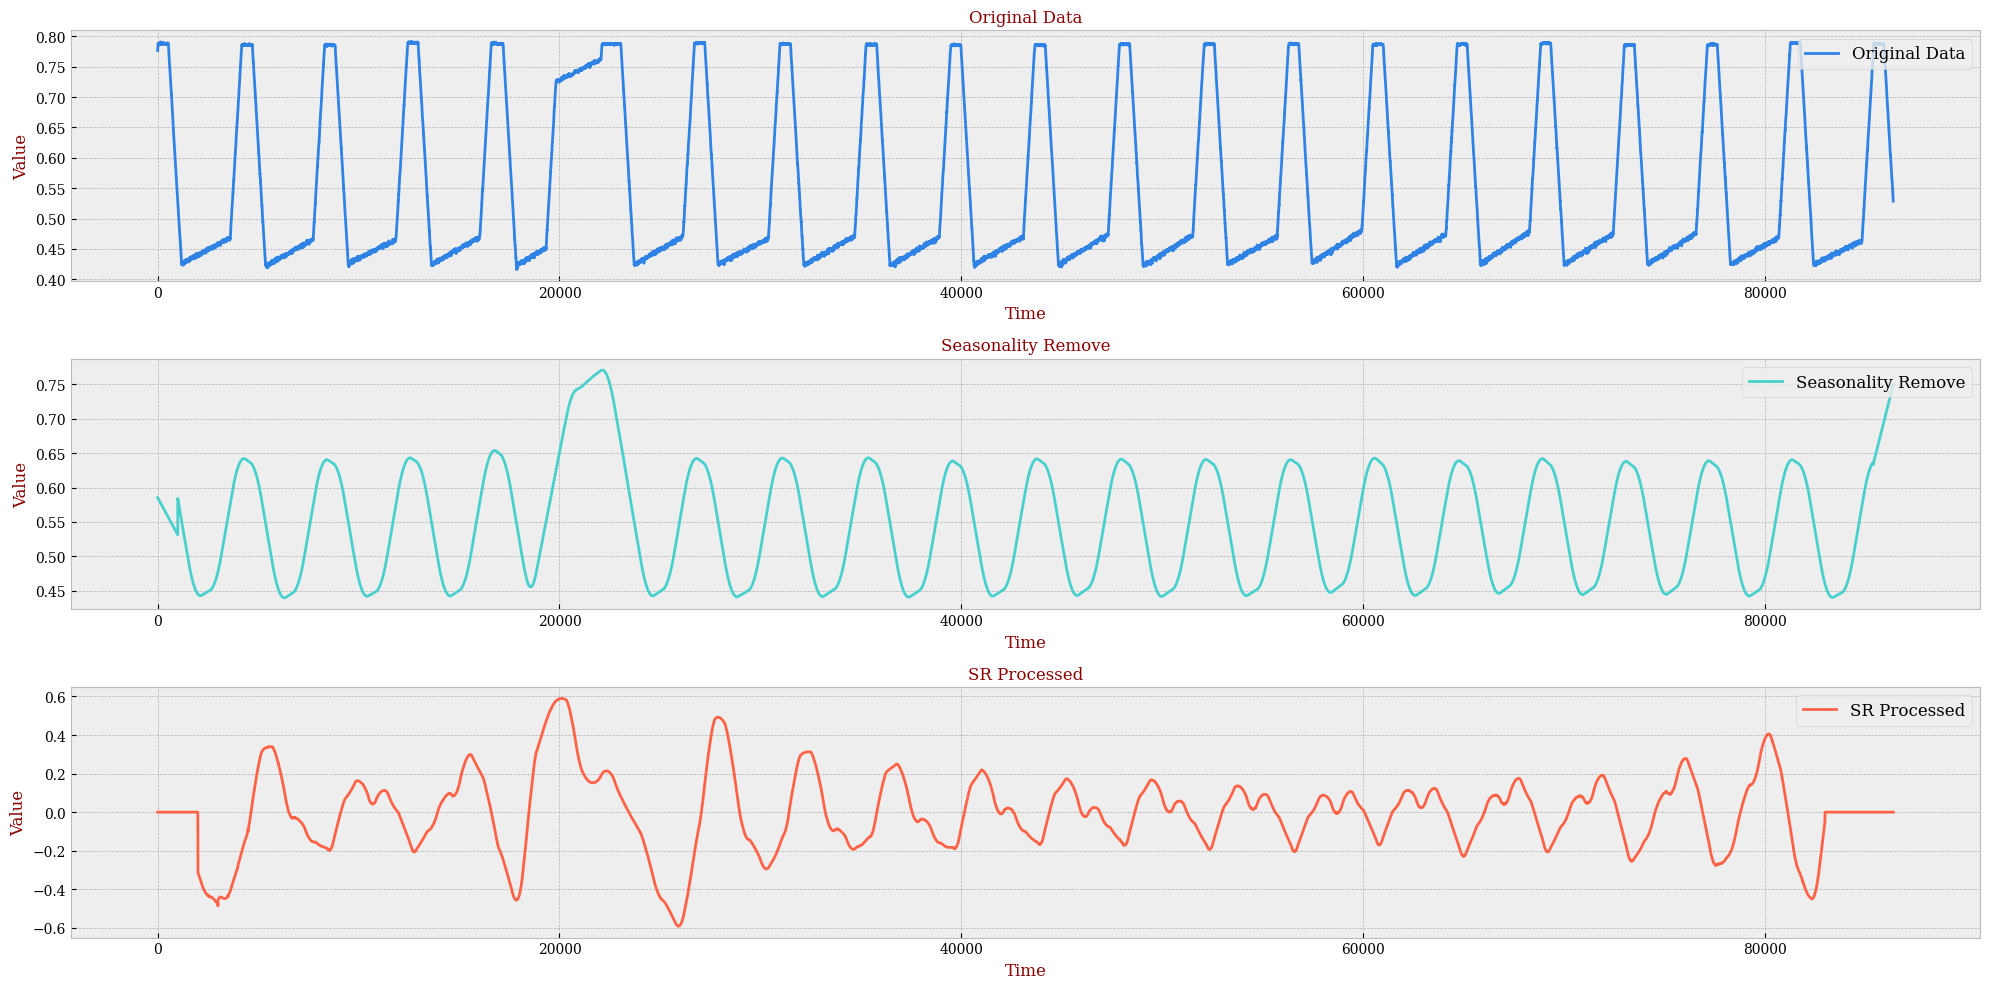

In [20]:
x = range(idx_end - idx_start)

with plt.style.context('bmh'):
    font = {'color': 'darkred', 'size': 12, 'family': 'serif'}
    font_legend = {'size': 12, 'family': 'serif'}

    fig, axs = plt.subplots(3, 1, figsize=(20, 10))

    axs[0].plot(x, sample, label='Original Data', color='#2f83e4')
    axs[0].set_xlabel('Time', fontdict=font)
    axs[0].set_ylabel('Value', fontdict=font)
    axs[0].set_title('Original Data', fontdict=font)
    axs[0].legend(loc='upper right', prop=font_legend)
    labels = axs[0].get_xticklabels() + axs[0].get_yticklabels()
    [label.set_fontname('serif') for label in labels]

    axs[1].plot(x, trend, label='Seasonality Remove', color='mediumturquoise')
    axs[1].set_xlabel('Time', fontdict=font)
    axs[1].set_ylabel('Value', fontdict=font)
    axs[1].set_title('Seasonality Remove', fontdict=font)
    axs[1].legend(loc='upper right', prop=font_legend)
    labels = axs[1].get_xticklabels() + axs[1].get_yticklabels()
    [label.set_fontname('serif') for label in labels]

    axs[2].plot(x, anomaly_score, label='SR Processed', color='tomato')
    axs[2].set_xlabel('Time', fontdict=font)
    axs[2].set_ylabel('Value', fontdict=font)
    axs[2].set_title('SR Processed', fontdict=font)
    axs[2].legend(loc='upper right', prop=font_legend)
    labels = axs[2].get_xticklabels() + axs[2].get_yticklabels()
    [label.set_fontname('serif') for label in labels]

plt.tight_layout()
plt.savefig('../fig/swat-2015-seasonal-sr.png')